In [1]:
#Load Modules
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from datetime import datetime
import io
import requests
import pycountry
import math
NCountries = 0

In [2]:
def CreatePlots(df,key,tit, isLog=True, isReturn=False,x0=0):
    #Create ploys of a specified key, a logarithmic plot is possible
    v = df[key].values[0]
    if isLog:
        fig,axes = plt.subplots(2,1)
        axes[1].plot(v[x0:],marker='.')
        axes[1].set_title(tit+'-lograithmic')
        axes[1].set_yscale('log')
        axes[0].plot(v[x0:], marker='.')
        axes[0].set_title(tit+'-linear')
    else:
        axes,fig = plt.subplots(1,1)
        plt.plot(v[x0:], marker='.')
        plt.title(tit+'-linear')
    if isReturn:
        return axes
    #df.plot(y=key, marker = '.', ax=axes[0], title=tit+'-linear')
    #df.plot(y=key, marker = '.', ax=axes[1], title=tit+'-lograithmic', logy=True)

In [3]:
def AddMarksToPlot(axes,x,y,tit):
    #add markers at specified points
    if isinstance(axes,np.ndarray):
        for ax in axes:
            ax.scatter(x,y,color='r',zorder=0)
            for xi,yi in zip(x,y):
                ax.annotate(tit,(xi,yi))
    else:
        axes.scatter(x,y,marker='.',color='r',zorder=0)
        for xi,yi in zip(x,y):
                ax.annotate(tit,(xi,yi))

In [4]:
def deriveatives(df, tit, isPlot = True, key='cases',prefix=''):
    #Calculate first and second derivative and insert them into the dataframe with a specified prefix
    #v = np.array(df['cases'].values)
    v = np.array(df[key].values.tolist())
    d1 = (v[:,2:] - v[:,0:-2])/2
    d2 = (v[:,2:] - 2*v[:,1:-1] + v[:,0:-2])
    d1str = prefix+'first_derivative'
    d2str = prefix+'second_derivative'
    df[d1str] = d1.tolist()
    df[d2str] = d2.tolist()
    if isPlot:
        CreatePlots(df[df['Country/Region']=='worldwide'], d1str, tit+'1st derivative',isLog=False)
        CreatePlots(df[df['Country/Region']=='worldwide'], d2str, tit+'2nd derivative',isLog=False)
    return df

In [5]:
def AddExtremaToPlot(df,ax,key,d1Key,tol,MaxTit='maximum',MinTit='minimum'):
    indMax,indMin = FindExtrema(df,d1Key,tol)
    v = np.squeeze(np.array(df[key].values.tolist()))
    s = max(v.shape) - max(indMax.shape)
    temp = np.zeros(round(s/2),dtype=bool)
    indMax = np.concatenate((temp,indMax,temp))#Pad the indices with False from both sides
    #indMax = np.concatenate(([False],indMax,[False]))
    AddMarksToPlot(ax,np.argwhere(indMax),v[indMax],MaxTit)
    #indMin = np.concatenate(([False],indMin,[False]))
    indMin = np.concatenate((temp,indMin,temp))
    AddMarksToPlot(ax,np.argwhere(indMin),v[indMin],MinTit)

In [6]:
def rolling_window(a, window):
    #rolling window to smooth the data
    a = np.array(a)
    shape = a.shape[:-1] + (a.shape[-1] - window + 1, window)
    strides = a.strides + (a.strides[-1],)
    return np.lib.stride_tricks.as_strided(a, shape=shape, strides=strides)

In [7]:
def FindExtrema(df,d1key,tol,lim=5):
    #find zeros of given derivative, classify into maxima and minima, and return indinces
    d1val = np.array(df[d1key].values.tolist())
    indEx = abs(d1val) <= tol
    zero_crossingsMin = np.squeeze(np.array(np.where(np.diff(np.sign(d1val))>0)))
    zero_crossingsMax = np.squeeze(np.array(np.where(np.diff(np.sign(d1val))<0)))
    d2 = np.insert(np.squeeze(np.diff(d1val)),0,0)
    indMin = np.zeros(d1val.shape[1],dtype=bool)
    indMax = np.zeros(d1val.shape[1],dtype=bool)
    indMax[zero_crossingsMax] = True
    indMin[zero_crossingsMin] = True
    indMax = np.logical_and(indMax,abs(d2)>tol) 
    indMin = np.logical_and(indMin,abs(d2)>tol) 
    indMin[0:lim] = False#to avoid edge effects from initial noisy data
    indMax[0:lim] = False
    return indMax,indMin

In [8]:
def manager(df,tit,KeyList,isOrganize = True, isSum=True, isPlot=True):
    #Manages the organisation and reading of the data recieved from the repository
    if isOrganize:
        df = OrganizeDf(df, KeyList)
    if isSum:
        tot = pd.DataFrame(df.cases.tolist()).sum(0)
        df.loc[len(df.index)] = ['worldwide','worldwide',tot.values]
    if isPlot:
        CreatePlots(df[df['Country/Region']=='worldwide'], 'cases', tit)
    df = deriveatives(df, tit, isPlot)
    return df

In [9]:
def ShowData(df_current,key,d1key,d2key,tol1,tol2,isPlot1d=False,isPlot2d=False,tit=''):
    #plot data, add markers, and plot derivatives if desired
    #in order to not display extremum markers, set tol1 or tol2 to infinity
    if tit=='':
        tit = key
    ax = CreatePlots(df_current, key, tit,isReturn=True)
    AddExtremaToPlot(df_current,ax,key,d1key,tol1)#plot 1st derivative
    AddExtremaToPlot(df_current,ax,key,d2key,tol2,MaxTit='inflection',MinTit='inflection')#plot 2nd derivative
    if isPlot1d:
        CreatePlots(df_current, d1key, tit,isReturn=False)
    if isPlot2d:
        CreatePlots(df_current, d2key, tit,isReturn=False)

In [10]:
def AddCountryCode(df,key='Country/Region'):
#insert alpha-3 code for each country
    def FindCountry(x):
        try:
            return pycountry.countries.lookup(x).alpha_3
        except:
            return x[0:3].upper()
    df['country-alpha3'] = df[key].apply(lambda x:FindCountry(x))
    return df

In [11]:
def ewma_vectorized(data, alpha, offset=None, dtype=None, order='C', out=None):
    """
    Calculates the exponential moving average over a vector.
    Will fail for large inputs.
    :param data: Input data
    :param alpha: scalar float in range (0,1)
        The alpha parameter for the moving average.
    :param offset: optional
        The offset for the moving average, scalar. Defaults to data[0].
    :param dtype: optional
        Data type used for calculations. Defaults to float64 unless
        data.dtype is float32, then it will use float32.
    :param order: {'C', 'F', 'A'}, optional
        Order to use when flattening the data. Defaults to 'C'.
    :param out: ndarray, or None, optional
        A location into which the result is stored. If provided, it must have
        the same shape as the input. If not provided or `None`,
        a freshly-allocated array is returned.
    """
    data = np.array(data, copy=False)

    if dtype is None:
        if data.dtype == np.float32:
            dtype = np.float32
        else:
            dtype = np.float64
    else:
        dtype = np.dtype(dtype)

    if data.ndim > 1:
        # flatten input
        data = data.reshape(-1, order)

    if out is None:
        out = np.empty_like(data, dtype=dtype)
    else:
        assert out.shape == data.shape
        assert out.dtype == dtype

    if data.size < 1:
        # empty input, return empty array
        return out

    if offset is None:
        offset = data[0]

    alpha = np.array(alpha, copy=False).astype(dtype, copy=False)

    # scaling_factors -> 0 as len(data) gets large
    # this leads to divide-by-zeros below
    scaling_factors = np.power(1. - alpha, np.arange(data.size + 1, dtype=dtype),
                               dtype=dtype)
    # create cumulative sum array
    np.multiply(data, (alpha * scaling_factors[-2]) / scaling_factors[:-1],
                dtype=dtype, out=out)
    np.cumsum(out, dtype=dtype, out=out)

    # cumsums / scaling
    out /= scaling_factors[-2::-1]

    if offset != 0:
        offset = np.array(offset, copy=False).astype(dtype, copy=False)
        # add offsets
        out += offset * scaling_factors[1:]

    return out

In [12]:
def OrganizeDf(df, KeyList):
    #This function organizes the Dataframe, so that the dates won't be column names, 
    #and each row will be a country caontaining a vector of cases every day
    v = df[KeyList[4:]].values
    #if (v.shape[0] < NCountries - 1):
    #    temp = np.zeros((NCountries - v.shape[0],v.shape[1]))
    #    np.concatenate((v,temp),axis=0)
    #ind = df["Country/Region"].str.index("Kosovo")
    #print(v[ind,:])
    df['cases'] = v.tolist()
    df = df.drop(KeyList[4:],axis = 1)
    df = df.drop(['Lat','Long'], axis = 1)
    return df

In [13]:
#get the data and create data frames
url_confirm = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv'
url_dead ='https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv'
url_recover='https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_recovered_global.csv'
urls = [url_confirm,url_dead,url_recover]
NewKeys = ['confirmed','dead','recovered']#names of keys
PlotTitle = ['confirmed','dead','recovered']#titles of plots corresponding to the data
NCountries=0

for i,u in enumerate(urls):
    temp_df = pd.read_csv(u)
    KeyList = temp_df.keys()
    temp_df = manager(temp_df, PlotTitle[i], KeyList, isOrganize = True, isSum=True, isPlot=False)
    if i==0:
        d1 = datetime.strptime(KeyList[4], "%m/%d/%y")
        d2 = datetime.strptime(KeyList[-1], "%m/%d/%y")
        NDays = abs((d2 - d1).days)
        NCountries = len(temp_df.index)
        dateVec = KeyList[4:]
        df = temp_df
    else:
        df = pd.merge(df,temp_df,how='outer',on=['Country/Region',"Province/State"])
    df = df.rename(columns={"cases":NewKeys[i]+'_cases'})
    df = df.rename(columns={"first_derivative":NewKeys[i]+'_first_derivative'})
    df = df.rename(columns={"second_derivative":NewKeys[i]+'_second_derivative'})

DataTagsList = ['confirm_df','dead_df','recover_df']
df = df.drop(df.index[-1])

In [14]:
print(df.tail())

[list([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2])
 list([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 10, 17, 17, 31])
 list([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 8, 12, 12, 12, 12, 12, 32, 32, 32, 65, 65, 24, 65, 29, 29])
 list([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])
 list([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

In [21]:
#Calculate active cases and add them to the dataframe
tol = 10#tolerance used for finding extrema and inflection points

for row in df.loc[df.recovered_cases.isnull(), 'recovered_cases'].index:#clear from NaN
    df.at[row, 'recovered_cases'] = [0]*(NDays+1)
print(np.stack(df['recovered_cases'].to_numpy()))

active_temp = np.stack(df['confirmed_cases'].to_numpy())- np.stack(df['dead_cases'].to_numpy()) - np.stack(df['recovered_cases'].to_numpy())

df['active_cases'] = active_temp.tolist()
df = deriveatives(df, 'active cases', isPlot = False, key='active_cases',prefix='active_')
worldwide = df[df['Country/Region']=='worldwide']

66
65
[[     0      0      0 ...      2      2      2]
 [     0      0      0 ...     17     17     31]
 [     0      0      0 ...     65     29     29]
 ...
 [     0      0      0 ...      0      0      1]
 [     0      0      0 ...      0      0      0]
 [    28     30     36 ... 113787 122150 130915]]


In [16]:
#Find point for 100th patient


In [17]:
#Smoothing active cases
df['smooth_active']=df['active_cases'].apply(lambda x: np.mean(rolling_window(x, 5), 1))
df = deriveatives(df, '', isPlot = False, key='smooth_active',prefix='smooth_active_')

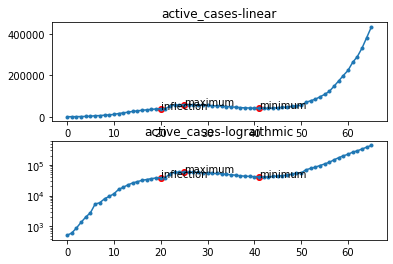

In [18]:
worldwide = df[df['Country/Region']=='worldwide']
ShowData(worldwide,'active_cases','smooth_active_first_derivative','smooth_active_second_derivative',10,1000,tit='')

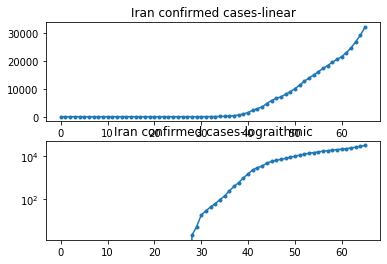

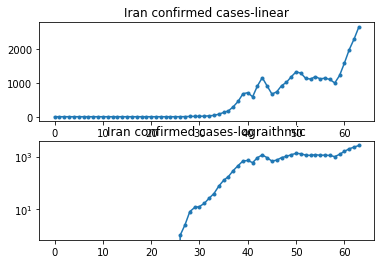

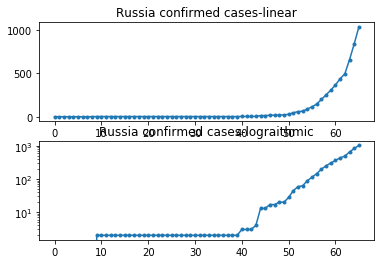

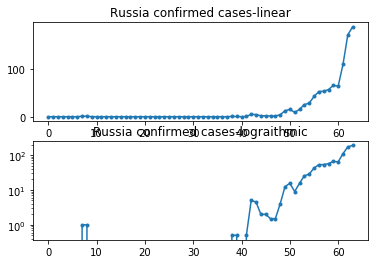

In [19]:
#countries
CList = ['Iran','Russia']#['China','Italy','Korea, South','Israel','US','Japan']
keyList = df.keys()
keyList = keyList[2:]
#df[['active_cases','confirmed_cases','dead_cases','recovered_cases']].groupby('Country/Region')
for c in CList:
    temp_df = df[df['Country/Region']==c]
    country_df = temp_df.iloc[[0]]
    country_df['Province/State']='all'
    #country_df = country_df.groupby(['Country/Region'],as_index=False)
    #print(country_df.head())
    for k in keyList:
        tot = pd.DataFrame(temp_df[k].tolist()).sum(0)
        country_df[k] = [tot.values.tolist()]
    #df.loc[-1] = ['worldwide','worldwide',tot.values]
    #
    ShowData(country_df,'confirmed_cases','confirmed_first_derivative','confirmed_second_derivative',10,10000,isPlot1d=True,tit=c+' confirmed cases')
    #ShowData(country_df,'active_cases','smooth_active_first_derivative','smooth_active_second_derivative',10,500,tit=c+' active cases')

In [20]:
#load number of COVID tests in each country
url_tests = 'covid-19-tests-country.csv'
test_df = pd.read_csv(url_tests)
test_df = test_df[test_df['Code'].notna()]
df = AddCountryCode(df)
test_df = test_df.rename(columns={"Code": "country-alpha3"})
df.map(test_df.set_index('country-alpha3')['Total COVID-19 tests'])
#df.merge(test_df,on='country-alpha3')
print(df.head())

AttributeError: 'DataFrame' object has no attribute 'map'

In [ ]:
print(df.head)